In [207]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
import warnings
warnings.filterwarnings('ignore')

Using cuda device


In [3]:
fname = join(os.getcwd(),'data','data3SS2009.mat')

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = np.int32(mat_contents['labels'].reshape(Nc))

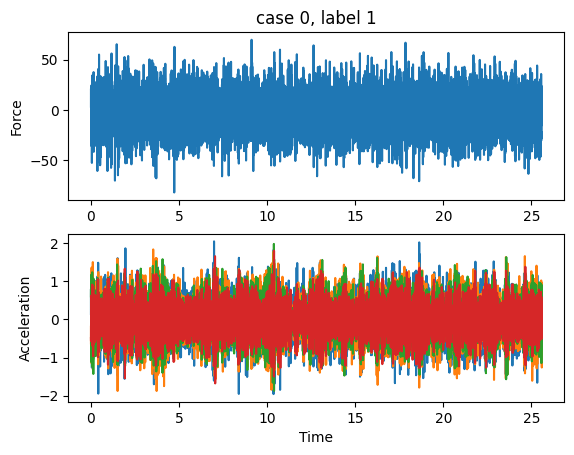

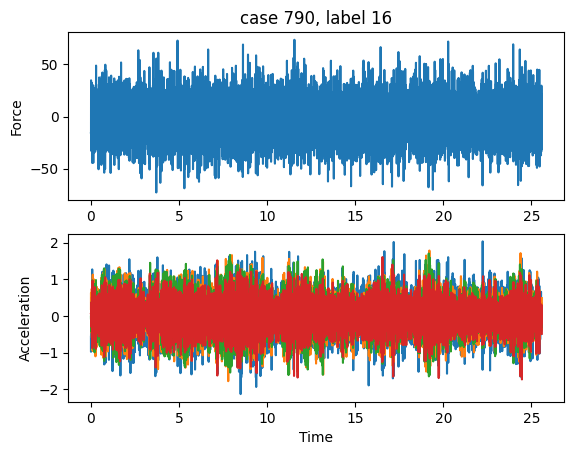

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [5]:
Ch2_ar = []
for i in range(850):
    res = AutoReg(Ch2.T[i], lags = 30).fit()
    Ch2_ar.append(res.params)
Ch3_ar = []
for i in range(850):
    res = AutoReg(Ch3.T[i], lags = 30).fit()
    Ch3_ar.append(res.params)
Ch4_ar = []
for i in range(850):
    res = AutoReg(Ch4.T[i], lags = 30).fit()
    Ch4_ar.append(res.params)
Ch5_ar = []
for i in range(850):
    res = AutoReg(Ch5.T[i], lags = 30).fit()
    Ch5_ar.append(res.params)

X1 = np.concatenate((Ch2_ar, Ch3_ar, Ch4_ar, Ch5_ar), axis = 1)
X1.shape

(850, 124)

In [26]:
pca = PCA(n_components=0.95)
X = pca.fit(X1).transform(X1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

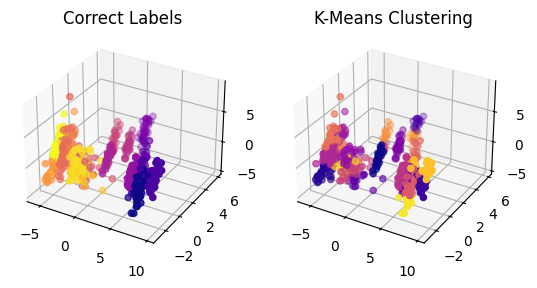

In [30]:
n_clusters = 24

kmeans = KMeans(n_clusters= n_clusters, random_state=42, n_init = 10)
kmeans.fit(X_train, y_train)
labels = kmeans.labels_

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, marker='o', cmap='plasma')
ax1.set_title('Correct Labels')

ax2.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=labels, marker='o', cmap='plasma')
ax2.set_title('K-Means Clustering')


plt.show()

In [45]:
cluster_labels = kmeans.fit_predict(X)
cluster_to_majority_class = {}

for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_true_labels = y[cluster_indices]
    majority_class = np.bincount(cluster_true_labels).argmax()
    cluster_to_majority_class[cluster] = majority_class

assigned_labels = [cluster_to_majority_class[cluster] for cluster in cluster_labels]

confusion = confusion_matrix(y, assigned_labels)
accuracy = accuracy_score(y, assigned_labels)

print(confusion)

[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [11 38  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 39 11  0]
 [ 0  0  0  0  0  0  0  0  0  0 21  0 10  1  1  0 17]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  9 29  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0 12  0 30  4  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 47  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3 46  1]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  1  2  0  0 43]]


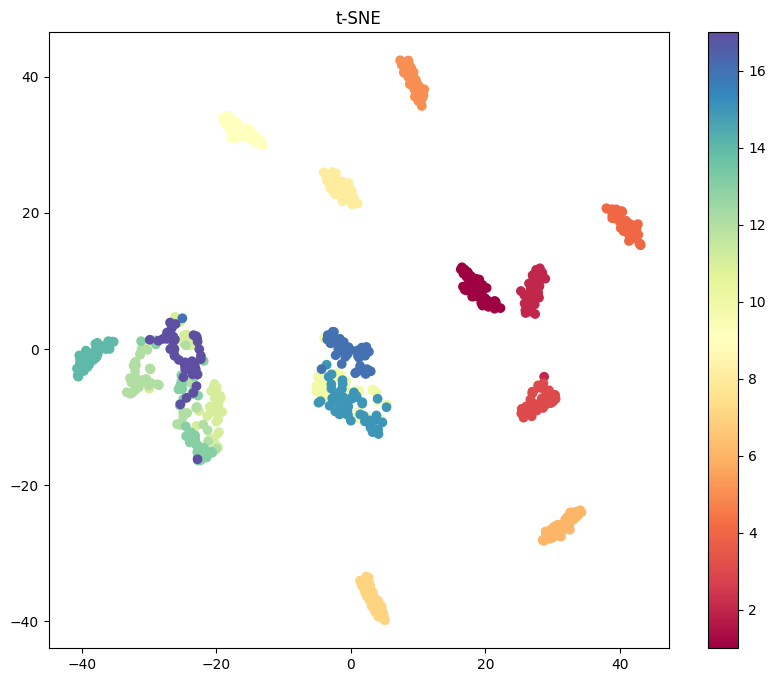

In [50]:
tsne = TSNE(n_components=2, random_state=42)
X_2D = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap=plt.cm.Spectral) 
plt.title("t-SNE")
plt.colorbar()
plt.show()

Accuracy: 0.4117647058823529
Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00       184
           1       0.45      0.90      0.60       156

    accuracy                           0.41       340
   macro avg       0.15      0.30      0.20       340
weighted avg       0.20      0.41      0.27       340



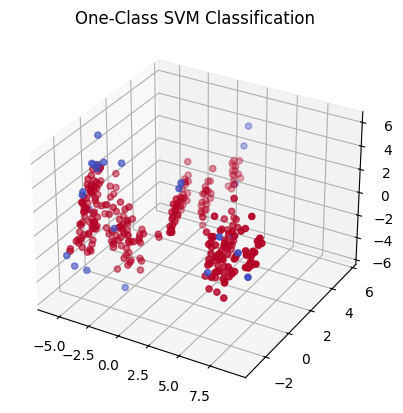

In [61]:
#  1-9 is'undamaged' and 10-17 is 'damaged'
y_binary = np.where(y <= 9, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.4, random_state=42)

clf = svm.OneClassSVM(kernel='rbf', nu=0.1)  
clf.fit(X_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,)

print(f'Accuracy: {accuracy}')
print(f'Report:\n{report}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred, cmap='coolwarm')
plt.title('One-Class SVM Classification')
plt.show()

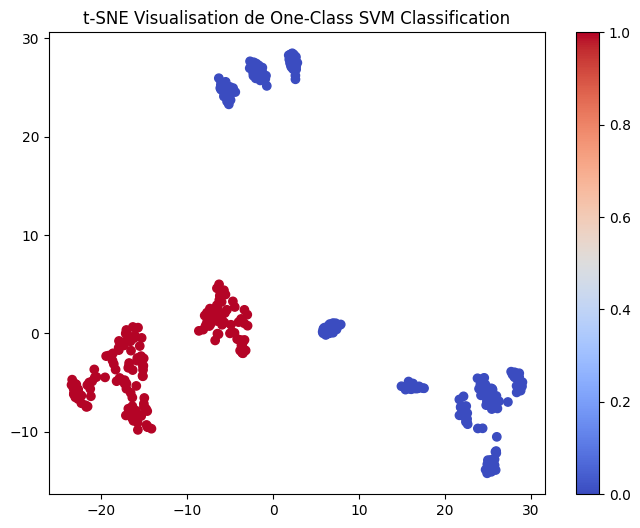

In [62]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_test)

# Visualize the t-SNE plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='coolwarm')
plt.title('t-SNE Visualisation de One-Class SVM Classification')
plt.colorbar()
plt.show()

In [311]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.m1 = nn.Linear(6, 40)
        self.m2 = nn.Linear(40, 80)
        self.m3 = nn.Linear(80, 40)
        self.m4 = nn.Linear(40, 1)
        self.activation = nn.Softmax()

    def forward(self, x):
        x = self.activation(self.m1(x))
        x = self.activation(self.m2(x))
        x = self.activation(self.m3(x))
        x = self.m4(x)
        return x

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [312]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape

(680, 6)

In [313]:
net = NeuralNetwork()
L = nn.MSELoss()
opt = torch.optim.SGD(net.parameters(), lr=1e-1)

In [314]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [315]:
losses = []
for _ in range(100):
    opt.zero_grad()
    loss_value = L(net(X_train), y_train)
    loss_value.backward()
    opt.step()
    losses.append(loss_value.item())

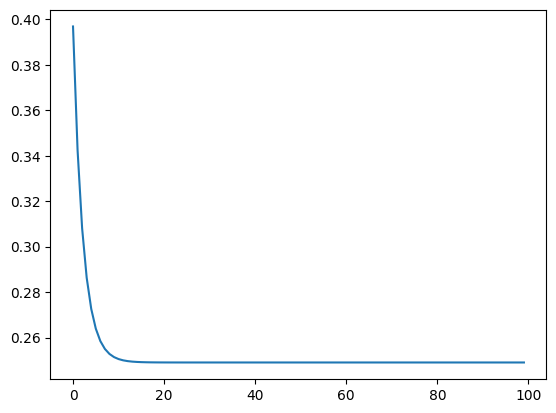

In [316]:
plt.plot(losses)
#plt.yscale('log')

In [317]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [320]:
print('accuracy:', 1-L(net(X_train),y_train).item())

accuracy: 0.7509537190198898


In [194]:
!pip install --upgrade tensorflow

     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     ---------------------------------------- 0.0/65.5 kB ? eta -:--:--
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ------ --------------------------------- 0.3/1.5 MB 5.2 MB/s eta 0:00:01
     ------------ --------------------------- 0.5/1.5 MB 4.9 MB/s eta 0:00:01
     ------------------ --------------------- 0.7/1.5 MB 4.7 MB/s eta 0:00:01
     ------------------------- -------------- 1.0/1.5 MB 5.0 MB/s eta 0:00:01
     ------------------------------- -------- 1.2/1.5 MB 5.0 MB/s eta 0:00:01
     ------------------------------------- -- 1.4/1.5 MB 5.2 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/181.3 kB ? eta -:--:--
     --------

In [198]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(18, activation='softmax')  ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=80, batch_size=32, validation_split=0.1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {test_accuracy:.4f}')

predictions = model.predict(X_test)

Epoch 1/80
20/20 [==============================] - 1s 11ms/step - loss: 2.8045 - accuracy: 0.1356 - val_loss: 2.6711 - val_accuracy: 0.3088
Epoch 2/80
20/20 [==============================] - 0s 3ms/step - loss: 2.5803 - accuracy: 0.3693 - val_loss: 2.4573 - val_accuracy: 0.4706
Epoch 3/80
20/20 [==============================] - 0s 4ms/step - loss: 2.3394 - accuracy: 0.5147 - val_loss: 2.1939 - val_accuracy: 0.5147
Epoch 4/80
20/20 [==============================] - 0s 3ms/step - loss: 2.0413 - accuracy: 0.5703 - val_loss: 1.8924 - val_accuracy: 0.5294
Epoch 5/80
20/20 [==============================] - 0s 3ms/step - loss: 1.7124 - accuracy: 0.6340 - val_loss: 1.5820 - val_accuracy: 0.6765
Epoch 6/80
20/20 [==============================] - 0s 3ms/step - loss: 1.3848 - accuracy: 0.7141 - val_loss: 1.2780 - val_accuracy: 0.7353
Epoch 7/80
20/20 [==============================] - 0s 3ms/step - loss: 1.0838 - accuracy: 0.7892 - val_loss: 1.0022 - val_accuracy: 0.7794
Epoch 8/80
20/20 [=